Những câu hỏi cần trả lời qua EDA:

1. Dữ liệu có "sạch" không? Có giá trị thiếu hay ngoại lai bất thường không?

2. Tần suất lấy mẫu có đều không? Các khoảng Δt lớn nhất/nhỏ nhất là bao nhiêu?

3. Phạm vi hoạt động của UAV trong không gian (min/max của tx, ty, tz) là gì?

4. Quỹ đạo có những đặc điểm nổi bật nào (ví dụ: bay thẳng, lượn vòng, thay đổi độ cao đột ngột)?

5. Tốc độ và gia tốc (ước lượng) của UAV có hợp lý không? Có những thay đổi đột ngột nào không?

6. Khoảng cách di chuyển giữa các điểm liên tiếp có phù hợp với một UAV bay trong 1 giây không?

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('../data/processed/uav_hugging_face_dropped_20.csv')
# df = pd.read_csv('../data/processed/uav_remain_80.csv')

In [3]:
df

,timestamp,tx,ty,tz
0,1.700283e+09,13.014602,-19.972520,12.583942
1,1.700283e+09,12.681959,-20.148311,12.704661
2,1.700283e+09,12.576914,-20.362126,12.701658
3,1.700283e+09,12.474667,-20.649468,12.698879
4,1.700283e+09,12.279036,-21.717916,12.706648
...,...,...,...,...
127,1.700283e+09,7.540815,-20.199480,12.745961
128,1.700283e+09,7.012607,-20.482143,12.775705
129,1.700283e+09,6.798274,-20.639954,12.800359
130,1.700283e+09,6.642670,-20.793173,12.817125


In [4]:
# Kiểm tra kiểu dữ liệu và giá trị thiếu
print(df.info())
print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  132 non-null    float64
 1   tx         132 non-null    float64
 2   ty         132 non-null    float64
 3   tz         132 non-null    float64
dtypes: float64(4)
memory usage: 4.2 KB
None

Số lượng giá trị thiếu mỗi cột:
timestamp    0
tx           0
ty           0
tz           0
dtype: int64


In [5]:
# Thống kê mô tả cho các tọa độ:

print("\nThống kê mô tả cho các tọa độ:")
print(df[['tx', 'ty', 'tz']].describe())



Thống kê mô tả cho các tọa độ:
               tx          ty          tz
count  132.000000  132.000000  132.000000
mean    10.279793  -23.969460   12.787837
std      2.618296    2.971636    0.051853
min      6.309179  -28.408181   12.583942
25%      7.622578  -26.851509   12.752346
50%     10.482745  -24.156858   12.788766
75%     12.780556  -20.961001   12.823561
max     13.793108  -19.591508   12.898398


In [6]:
# Chuyển đổi sang datetime (nếu chưa phải):

# df['timestamp'] = pd.to_datetime(df['timestamp'])
# Nếu timestamp của bạn là dạng số Unix (ví dụ: 1.700283e+09), bạn cần:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Sắp xếp theo thời gian (để đảm bảo tính tuần tự):

df = df.sort_values(by='timestamp').reset_index(drop=True)

# Tính toán khoảng thời gian giữa các điểm liên tiếp (Δt):

# (Trong phần Phân tích timestamp của Canvas uav_eda_steps_v1)
# ...
df['delta_t_seconds'] = df['timestamp'].diff().dt.total_seconds()
if len(df) > 1:
    median_delta_t = df['delta_t_seconds'].median()
    # Điền NaN ở hàng đầu tiên bằng median hoặc 1.0 nếu median là NaN (xảy ra nếu chỉ có 2 điểm)
    df['delta_t_seconds'].fillna(median_delta_t if pd.notna(median_delta_t) else 1.0, inplace=True)
elif len(df) == 1:
    df['delta_t_seconds'].fillna(1.0, inplace=True) # Trường hợp chỉ có 1 điểm

# Kiểm tra và xử lý các delta_t bằng 0 còn lại (nếu có)
zero_delta_t_mask = (df['delta_t_seconds'] == 0)
if zero_delta_t_mask.any():
    print(f"\nCẢNH BÁO: Tìm thấy {zero_delta_t_mask.sum()} giá trị delta_t_seconds bằng 0.")
    # Quyết định cách xử lý:
    # Lựa chọn 1: Thay bằng một giá trị nhỏ để tránh chia cho 0
    # df.loc[zero_delta_t_mask, 'delta_t_seconds'] = 1e-9
    # Lựa chọn 2: Hoặc coi như không có thay đổi thời gian, vận tốc sẽ là 0 (đã được xử lý bởi np.where)
    # Lựa chọn 3: Hoặc loại bỏ các điểm này nếu chúng là lỗi
    # df = df[~zero_delta_t_mask]
    # Hiện tại, np.where sẽ xử lý trường hợp này bằng cách gán vận tốc là 0, điều này có thể chấp nhận được.
# ...


/tmp/ipykernel_1799116/4021055154.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['delta_t_seconds'].fillna(median_delta_t if pd.notna(median_delta_t) else 1.0, inplace=True)


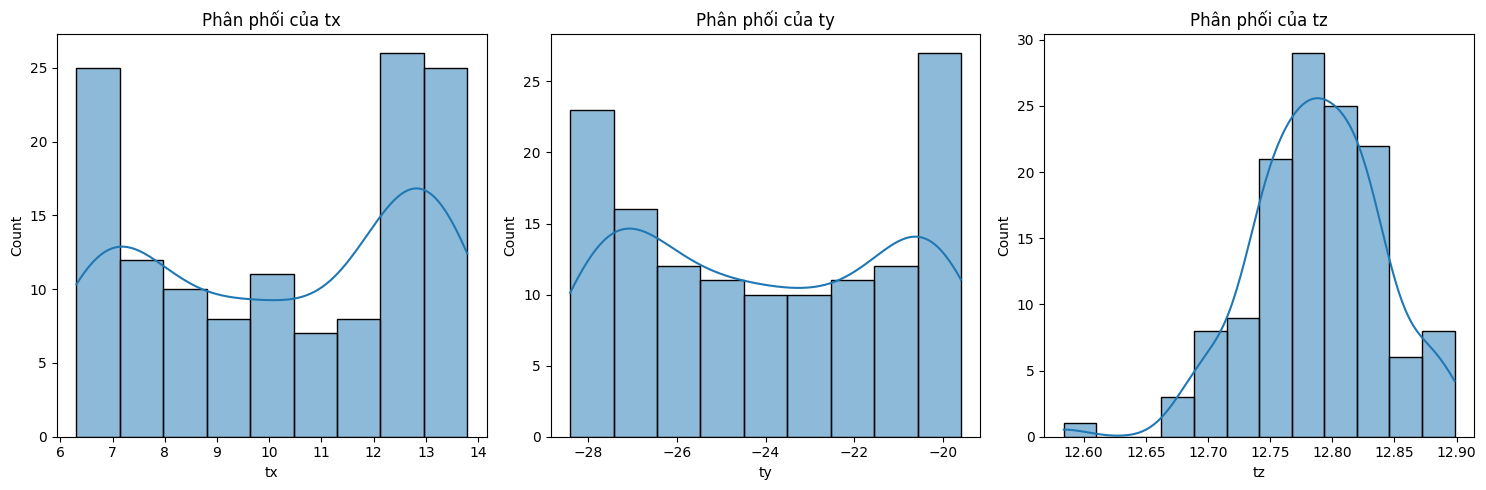

In [7]:
# Vẽ Histogram hoặc KDE (Kernel Density Estimate) cho tx, ty, tz:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
for i, col in enumerate(['tx', 'ty', 'tz']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Phân phối của {col}')
plt.tight_layout()
plt.show()

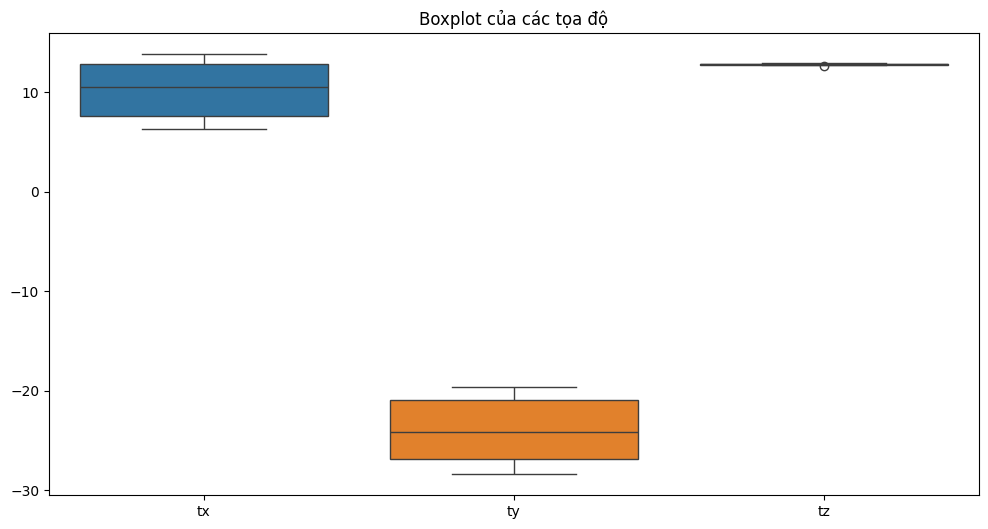

In [8]:
# Vẽ Box plots cho tx, ty, tz:

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['tx', 'ty', 'tz']])
plt.title('Boxplot của các tọa độ')
plt.show()


Thống kê về vận tốc tính toán (m/s):
               vx          vy          vz  speed_calculated
count  132.000000  132.000000  132.000000        132.000000
mean    -0.127707   -0.162137    0.009110          3.212391
std      2.781337    1.932546    0.105863          1.061393
min     -4.492327   -4.270234   -0.209054          0.000000
25%     -2.669234   -1.692115   -0.061832          2.264065
50%     -0.289125   -0.020332   -0.000146          3.367139
75%      2.288852    1.724319    0.072453          4.119297
max      4.443118    2.411019    0.301797          5.096907


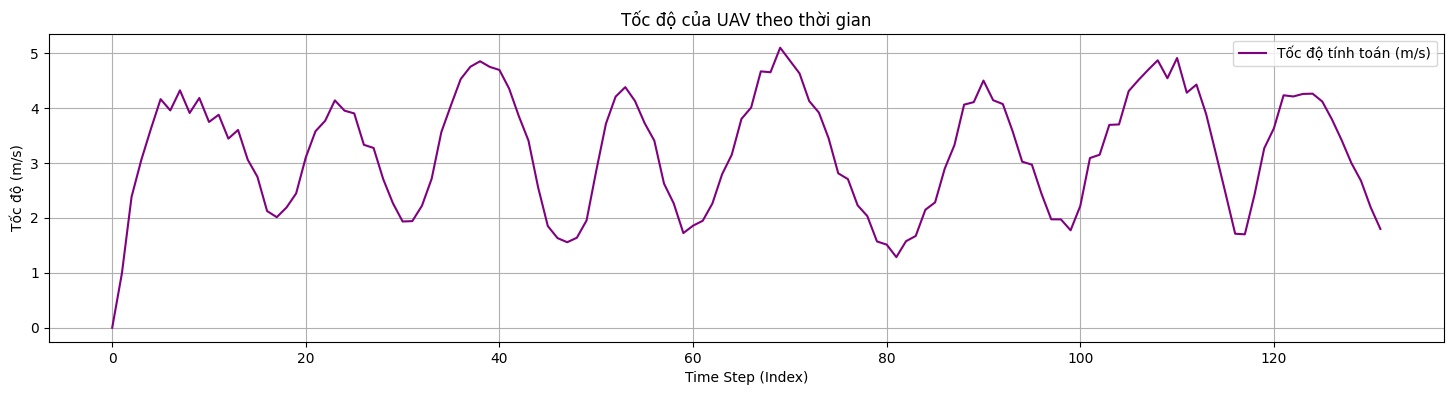

In [9]:
# Tính toán và trực quan hóa Vận tốc (Velocity):

# Vận tốc có thể được xấp xỉ bằng cách lấy sai phân của vị trí chia cho Δt.

# Tính sai phân vị trí
df['dx'] = df['tx'].diff()
df['dy'] = df['ty'].diff()
df['dz'] = df['tz'].diff()

# Tính vận tốc, đảm bảo không chia cho 0 hoặc delta_t quá nhỏ
# Nếu delta_t_seconds có thể là 0 hoặc rất nhỏ, cần xử lý cẩn thận
# Ở đây, chúng ta sẽ gán vận tốc là 0 cho điểm đầu tiên (do .diff() tạo NaN)
# và cho những nơi delta_t_seconds là 0 (nếu có và chưa được xử lý ở trên)

df['vx'] = np.where(df['delta_t_seconds'] > 1e-9, df['dx'] / df['delta_t_seconds'], 0)
df['vy'] = np.where(df['delta_t_seconds'] > 1e-9, df['dy'] / df['delta_t_seconds'], 0)
df['vz'] = np.where(df['delta_t_seconds'] > 1e-9, df['dz'] / df['delta_t_seconds'], 0)

# Điền NaN còn lại (ví dụ ở hàng đầu tiên do .diff() của vị trí) bằng 0
df.fillna({'vx':0, 'vy':0, 'vz':0, 'dx':0, 'dy':0, 'dz':0}, inplace=True)

# Tính toán tốc độ tổng hợp (magnitude of velocity)
df['speed_calculated'] = np.sqrt(df['vx']**2 + df['vy']**2 + df['vz']**2)

print("\nThống kê về vận tốc tính toán (m/s):")
print(df[['vx', 'vy', 'vz', 'speed_calculated']].describe())

plt.figure(figsize=(18, 4))
plt.plot(df.index, df['speed_calculated'], label='Tốc độ tính toán (m/s)', color='purple')
plt.xlabel('Time Step (Index)')
plt.ylabel('Tốc độ (m/s)')
plt.title('Tốc độ của UAV theo thời gian')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Tính toán và trực quan hóa Gia tốc (Acceleration) (Tùy chọn, có thể nhiễu):

# Tính sai phân vận tốc
df['dvx'] = df['vx'].diff()
df['dvy'] = df['vy'].diff()
df['dvz'] = df['vz'].diff()

df['ax'] = np.where(df['delta_t_seconds'] > 1e-9, df['dvx'] / df['delta_t_seconds'], 0)
df['ay'] = np.where(df['delta_t_seconds'] > 1e-9, df['dvy'] / df['delta_t_seconds'], 0)
df['az'] = np.where(df['delta_t_seconds'] > 1e-9, df['dvz'] / df['delta_t_seconds'], 0)

df.fillna({'ax':0, 'ay':0, 'az':0, 'dvx':0, 'dvy':0, 'dvz':0}, inplace=True)

df['acceleration_magnitude'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
print("\nThống kê về gia tốc tính toán (m/s^2):")
print(df[['ax', 'ay', 'az', 'acceleration_magnitude']].describe())


Thống kê về gia tốc tính toán (m/s^2):
               ax          ay          az  acceleration_magnitude
count  132.000000  132.000000  132.000000              132.000000
mean     0.026102   -0.041643   -0.003828                4.143599
std      4.165394    2.439558    0.633044                2.530743
min    -10.411248  -16.986759   -3.318246                0.000000
25%     -2.788415   -1.100430   -0.245890                2.488311
50%      0.216707   -0.032471    0.055846                3.591315
75%      2.908290    1.139053    0.326484                5.370462
max     12.168930    5.265042    1.417346               17.445619



Thống kê về khoảng cách di chuyển mỗi bước (mét):
count    132.000000
mean       0.527123
std        0.330764
min        0.000000
25%        0.295065
50%        0.416135
75%        0.754629
max        1.682537
Name: distance_per_step, dtype: float64


/tmp/ipykernel_1799116/1681878340.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['distance_per_step'].fillna(0, inplace=True)


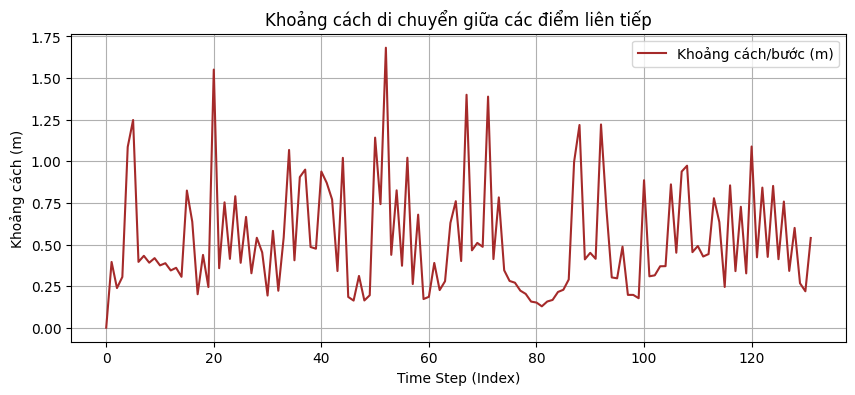

In [11]:
# Phân tích Khoảng cách di chuyển mỗi giây (Rất quan trọng, như đã thảo luận):
# (Sử dụng dx, dy, dz đã tính ở trên)

# df['dx'], df['dy'], df['dz'] đã được tính khi tính vận tốc
df['distance_per_step'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)
# Điểm đầu tiên sẽ có distance_per_step là NaN do dx,dy,dz là NaN, điền 0
df['distance_per_step'].fillna(0, inplace=True)

print("\nThống kê về khoảng cách di chuyển mỗi bước (mét):")
print(df['distance_per_step'].describe())

plt.figure(figsize=(10, 4))
plt.plot(df.index, df['distance_per_step'], label='Khoảng cách/bước (m)', color='brown')
plt.xlabel('Time Step (Index)')
plt.ylabel('Khoảng cách (m)')
plt.title('Khoảng cách di chuyển giữa các điểm liên tiếp')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# trực quan hóa đồ thị 3D

df_original = df

# --- BƯỚC 2: CHUYỂN ĐỔI TỌA ĐỘ (NẾU CẦN) VÀ CHỌN CỘT ĐỂ VẼ ---
# QUAN TRỌNG: Đảm bảo rằng các cột bạn sử dụng để vẽ ('tx', 'ty', 'tz' trong ví dụ của bạn,
# hoặc 'x_enu', 'y_enu', 'z_enu' như trong code này) đã ở cùng một đơn vị (ví dụ: mét)
# và đại diện cho tọa độ trong một hệ thống nhất quán (ví dụ: ENU).

# Giả sử dữ liệu mới của bạn có các cột 'tx', 'ty', 'tz' đã được xử lý (ví dụ: là tọa độ ENU)
# Nếu chưa, bạn cần thực hiện bước chuyển đổi ở đây.
# Để ví dụ này khớp với code trước, chúng ta sẽ giả lập việc tạo cột ENU.
# Trong THỰC TẾ, bạn sẽ dùng cột 'tx', 'ty', 'tz' từ dữ liệu mới của mình.

if 'tx' not in df_original.columns: # Chỉ giả lập nếu không có sẵn cột tx, ty, tz
    lat_ref = df_original['latitude'].iloc[0]
    lon_ref = df_original['longitude'].iloc[0]
    alt_ref = df_original['altitude'].iloc[0]
    R_earth = 6371000
    df_original['x_enu'] = (df_original['longitude'] - lon_ref) * np.pi/180 * R_earth * np.cos(df_original['latitude'] * np.pi/180)
    df_original['y_enu'] = (df_original['latitude'] - lat_ref) * np.pi/180 * R_earth
    df_original['z_enu'] = df_original['altitude'] - alt_ref # Hoặc giữ nguyên 'altitude' nếu nó đã là Z trong hệ ENU
    
    # Đổi tên để khớp với code vẽ của bạn nếu bạn muốn dùng 'tx', 'ty', 'tz'
    # Hoặc bạn có thể trực tiếp dùng 'x_enu', 'y_enu', 'z_enu' trong các lệnh plot
    df_original.rename(columns={'x_enu': 'tx', 'y_enu': 'ty', 'z_enu': 'tz'}, inplace=True)


# --- BƯỚC 3: CHỌN SỐ ĐIỂM DỮ LIỆU ĐỂ VẼ ---
# Ví dụ: lấy 220 điểm dữ liệu đầu tiên như trong ảnh bạn cung cấp
num_points_to_plot = 220
if len(df_original) >= num_points_to_plot:
    df_plot = df_original.head(num_points_to_plot).copy()
else:
    df_plot = df_original.copy() # Vẽ tất cả nếu không đủ 220 điểm
    print(f"Cảnh báo: Số lượng điểm dữ liệu ({len(df_original)}) ít hơn {num_points_to_plot}. Sẽ vẽ tất cả điểm hiện có.")



# --- Tạo đồ thị 3D với Plotly và Hoạt ảnh ---

# Tạo đối tượng Figure
fig = go.Figure()

# Khởi tạo trace cho các điểm scatter và đường line với điểm đầu tiên (hoặc không có điểm nào)
# Điều này quan trọng để cấu trúc của figure được thiết lập trước khi thêm frames
fig.add_trace(go.Scatter3d(
    x=[df_plot['tx'].iloc[0]], # Bắt đầu với điểm đầu tiên
    y=[df_plot['ty'].iloc[0]],
    z=[df_plot['tz'].iloc[0]],
    mode='markers',
    marker=dict(
        size=5, # Tăng kích thước điểm một chút để dễ thấy hơn
        color=[0], # Màu của điểm đầu tiên
        colorscale='Viridis',
        opacity=0.7,
        colorbar=dict(title=f'Time Steps (Up to {len(df_plot)} Points)')
    ),
    name='UAV Points'
))

fig.add_trace(go.Scatter3d(
    x=[df_plot['tx'].iloc[0]], # Bắt đầu với điểm đầu tiên
    y=[df_plot['ty'].iloc[0]],
    z=[df_plot['tz'].iloc[0]],
    mode='lines',
    line=dict(
        color='grey',
        width=2
    ),
    opacity=0.5,
    name='UAV Path'
))

# Tạo frames cho hoạt ảnh
# Mỗi frame sẽ thêm một điểm mới vào đồ thị
frames = []
for k in range(len(df_plot)):
    frame_data_points = go.Scatter3d(
        x=df_plot['tx'].iloc[:k+1],
        y=df_plot['ty'].iloc[:k+1],
        z=df_plot['tz'].iloc[:k+1],
        mode='markers',
        marker=dict(
            size=5,
            color=df_plot.index[:k+1], # Màu theo index của các điểm đã hiển thị
            colorscale='Viridis',
            opacity=0.7
            # Không cần colorbar ở đây vì nó đã được định nghĩa ở trace ban đầu
        )
    )
    frame_data_lines = go.Scatter3d(
        x=df_plot['tx'].iloc[:k+1],
        y=df_plot['ty'].iloc[:k+1],
        z=df_plot['tz'].iloc[:k+1],
        mode='lines',
        line=dict(color='grey', width=2),
        opacity=0.5
    )
    frames.append(go.Frame(data=[frame_data_points, frame_data_lines], name=str(k)))

fig.frames = frames

# Cập nhật layout của đồ thị
fig.update_layout(
    title=f'Animated UAV 3D Trajectory (First {len(df_plot)} Points) - Plotly',
    scene=dict(
        xaxis_title='X Position (m)',
        yaxis_title='Y Position (m)',
        zaxis_title='Z Position (m)',
        # Giữ nguyên cài đặt aspectmode, bạn có thể thử 'cube' nếu muốn
        aspectmode='data',
        # Đặt giới hạn trục cố định để tránh việc trục thay đổi kích thước khi hoạt ảnh
        # Điều này quan trọng để hoạt ảnh trông ổn định
        xaxis=dict(range=[df_plot['tx'].min() - 10, df_plot['tx'].max() + 10]),
        yaxis=dict(range=[df_plot['ty'].min() - 10, df_plot['ty'].max() + 10]),
        zaxis=dict(range=[df_plot['tz'].min() - 5, df_plot['tz'].max() + 20]), # Cho thêm không gian ở trục Z
    ),
    margin=dict(l=0, r=0, b=0, t=50), # Tăng lề trên một chút cho tiêu đề
    width=900,
    height=700,
    # Thêm nút Play và Slider cho hoạt ảnh
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        y=0, # Vị trí của nút play
        x=1.05, # Vị trí của nút play
        xanchor='left',
        yanchor='bottom',
        pad=dict(t=10, r=10),
        buttons=[dict(
            label='Play',
            method='animate',
            args=[None, dict(frame=dict(duration=100, redraw=True), # Tốc độ frame (ms)
                             fromcurrent=True,
                             transition=dict(duration=0))] # Không có hiệu ứng chuyển tiếp giữa các frame
        ),
                 dict(
            label='Pause',
            method='animate',
            args=[[None], dict(frame=dict(duration=0, redraw=False),
                               mode='immediate',
                               transition=dict(duration=0))]
        )]
    )],
    sliders=[dict(
        active=0,
        y=0, # Vị trí của slider
        x=0, # Vị trí của slider
        xanchor='left',
        yanchor='top',
        pad=dict(b=10, t=60), # Padding cho slider
        currentvalue=dict(
            font=dict(size=12),
            prefix='TimeStep: ',
            visible=True,
            xanchor='right'
        ),
        transition=dict(duration=0), # Không có hiệu ứng chuyển tiếp khi kéo slider
        steps=[dict(
            label=str(k),
            method='animate',
            args=[[str(k)], dict(mode='immediate',
                                 frame=dict(duration=0, redraw=True), # Không delay khi chọn frame
                                 transition=dict(duration=0))]
        ) for k in range(len(df_plot))]
    )]
)


# Hiển thị đồ thị (sẽ tương tác trong Jupyter Notebook/Lab)
fig.show()


Cảnh báo: Số lượng điểm dữ liệu (132) ít hơn 220. Sẽ vẽ tất cả điểm hiện có.
